# Long-Short Strategy, Part 1: Preparing Alpha Factors and Features

In this section, we'll start designing, implementing, and evaluating a trading strategy for US equities driven by daily return forecasts produced by gradient boosting models.

As in the previous examples, we'll lay out a framework and build a specific example that you can adapt to run your own experiments. There are numerous aspects that you can vary, from the asset class and investment universe to more granular aspects like the features, holding period, or trading rules. See, for example, the **Alpha Factor Library** in the [Appendix](../24_alpha_factor_library) for numerous additional features.

We'll keep the trading strategy simple and only use a single ML signal; a real-life application will likely use multiple signals from different sources, such as complementary ML models trained on different datasets or with different lookahead or lookback periods. It would also use sophisticated risk management, from simple stop-loss to value-at-risk analysis.

**Six notebooks** cover our workflow sequence:

1. `preparing_the_model_data` (this noteboook): we'll engineer a few simple features from the Quandl Wiki data 
2. [trading_signals_with_lightgbm_and_catboost](05_trading_signals_with_lightgbm_and_catboost.ipynb): we tune hyperparameters for LightGBM and CatBoost to select a model, using 2015/16 as our validation period. 
3. [evaluate_trading_signals](06_evaluate_trading_signals.ipynb): we compare the cross-validation performance using various metrics to select the best model. 
4. [model_interpretation](07_model_interpretation.ipynb): we take a closer look at the drivers behind the best model's predictions.
5. [making_out_of_sample_predictions](08_making_out_of_sample_predictions.ipynb): we generate predictions for our out-of-sample test period 2017.
6. [backtesting_with_zipline](09_backtesting_with_zipline.ipynb): evaluate the historical performance of a long-short strategy based on our predictive signals using Zipline.

## Imports & Settings

In [145]:
import warnings
warnings.filterwarnings('ignore')

In [146]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import talib
from talib import RSI, BBANDS, MACD, ATR

In [147]:
MONTH = 21
YEAR = 12 * MONTH

In [148]:
START = '2010-01-01'
END = '2017-12-31'

In [149]:
sns.set_style('darkgrid')
idx = pd.IndexSlice

In [150]:
percentiles = [.001, .01, .02, .03, .04, .05]
percentiles += [1-p for p in percentiles[::-1]]

In [151]:
T = [1, 5, 10, 21, 42, 63]

## Loading Quandl Wiki Stock Prices & Meta Data

In [152]:
DATA_STORE = '../data/assets.h5'
ohlcv = ['adj_open', 'adj_close', 'adj_low', 'adj_high', 'adj_volume']
with pd.HDFStore(DATA_STORE) as store:
    prices = (store['quandl/wiki/prices']
              .loc[idx[START:END, :], ohlcv] # select OHLCV columns from 2010 until 2017
              .rename(columns=lambda x: x.replace('adj_', '')) # simplify column names
              .swaplevel()
              .sort_index())
    metadata = (store['us_equities/stocks'].loc[:, ['marketcap', 'sector']])

In [153]:
prices.volume /= 1e3 # make vol figures a bit smaller
prices.index.names = ['symbol', 'date']
metadata.index.name = 'symbol'

## Remove stocks with insufficient observations

We require at least 7 years of data; we simplify and select using both in- and out-of-sample period; please be aware that it would be more accurate to use only the training period to remove data to avoid lookahead bias.

In [154]:
min_obs = 7 * YEAR
nobs = prices.groupby(level='symbol').size()
keep = nobs[nobs > min_obs].index
prices = prices.loc[idx[keep, :], :]

### Align price and meta data

In [155]:
metadata = metadata[~metadata.index.duplicated() & metadata.sector.notnull()]
metadata.sector = metadata.sector.str.lower().str.replace(' ', '_')

In [156]:
shared = (prices.index.get_level_values('symbol').unique()
          .intersection(metadata.index))
metadata = metadata.loc[shared, :]
prices = prices.loc[idx[shared, :], :]

### Limit universe to 1,000 stocks with highest market cap

Again, we simplify and use the entire sample period, not just the training period, to select our universe.

In [157]:
universe = metadata.marketcap.nlargest(1000).index
prices = prices.loc[idx[universe, :], :]
metadata = metadata.loc[universe]

In [158]:
metadata.sector.value_counts()

sector
consumer_services        187
finance                  168
technology               116
health_care              103
capital_goods             94
basic_industries          67
public_utilities          66
consumer_non-durables     61
energy                    51
consumer_durables         36
miscellaneous             28
transportation            23
Name: count, dtype: int64

In [159]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2004775 entries, ('AAPL', Timestamp('2010-01-04 00:00:00')) to ('NTCT', Timestamp('2017-12-29 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    2004775 non-null  float64
 1   close   2004775 non-null  float64
 2   low     2004775 non-null  float64
 3   high    2004775 non-null  float64
 4   volume  2004775 non-null  float64
dtypes: float64(5)
memory usage: 84.9+ MB


In [160]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, AAPL to NTCT
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   marketcap  1000 non-null   float64
 1   sector     1000 non-null   object 
dtypes: float64(1), object(1)
memory usage: 23.4+ KB


### Rank assets by Rolling Average Dollar Volume

#### Compute dollar volume

In [161]:
prices['dollar_vol'] = prices[['close', 'volume']].prod(1).div(1e3)

#### 21-day moving average

In [162]:
# compute dollar volume to determine universe
dollar_vol_ma = (prices
                 .dollar_vol
                 .unstack('symbol')
                 .rolling(window=21, min_periods=1) # 1 trading month
                 .mean())

#### Rank stocks by moving average

In [163]:
prices['dollar_vol_rank'] = (dollar_vol_ma
                            .rank(axis=1, ascending=False)
                            .stack('symbol')
                            .swaplevel())

In [164]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2004775 entries, ('AAPL', Timestamp('2010-01-04 00:00:00')) to ('NTCT', Timestamp('2017-12-29 00:00:00'))
Data columns (total 7 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             2004775 non-null  float64
 1   close            2004775 non-null  float64
 2   low              2004775 non-null  float64
 3   high             2004775 non-null  float64
 4   volume           2004775 non-null  float64
 5   dollar_vol       2004775 non-null  float64
 6   dollar_vol_rank  2004775 non-null  float64
dtypes: float64(7)
memory usage: 115.5+ MB


## Add some Basic Factors

See [appendix](../24_alpha_factor_library) for details on the below indicators.

### Compute the Relative Strength Index

In [165]:
prices.index.names


FrozenList(['symbol', 'date'])

In [166]:
# Define the RSI function (if you haven't already)
def RSI(series, period=14):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

# Apply the RSI function per symbol
rsi_values = prices.groupby(level='symbol')['close'].apply(RSI)

# Ensure the index alignment before assigning the result back to the dataframe
prices['rsi'] = rsi_values.values


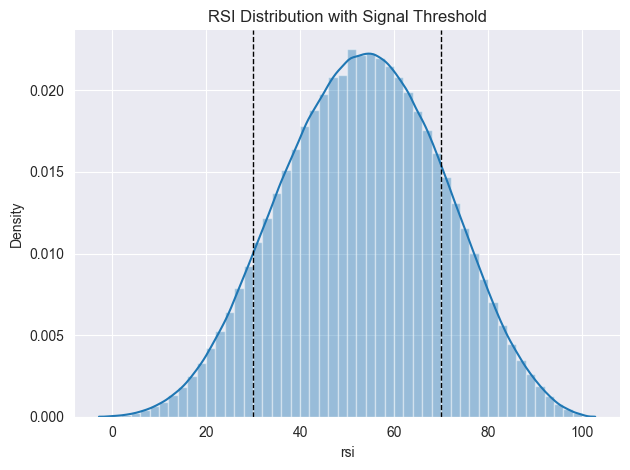

In [167]:
ax = sns.distplot(prices.rsi.dropna())
ax.axvline(30, ls='--', lw=1, c='k')
ax.axvline(70, ls='--', lw=1, c='k')
ax.set_title('RSI Distribution with Signal Threshold')
sns.despine()
plt.tight_layout();

### Compute Bollinger Bands

In [168]:
def compute_bb(series, window=20):
    rolling_mean = series.rolling(window=window).mean()
    rolling_std = series.rolling(window=window).std()
    upper_band = rolling_mean + (rolling_std * 2)
    lower_band = rolling_mean - (rolling_std * 2)
    return pd.DataFrame({'bb_high': upper_band, 'bb_low': lower_band})

# Apply Bollinger Bands and ensure index alignment
bb_values = prices.groupby(level='symbol')['close'].apply(compute_bb)


In [169]:
# Apply the Bollinger Bands calculation per symbol
prices[['bb_high', 'bb_low']] = bb_values[['bb_high', 'bb_low']].values


In [170]:
prices['bb_high'] = prices.bb_high.sub(prices.close).div(prices.bb_high).apply(np.log1p)
prices['bb_low'] = prices.close.sub(prices.bb_low).div(prices.close).apply(np.log1p)

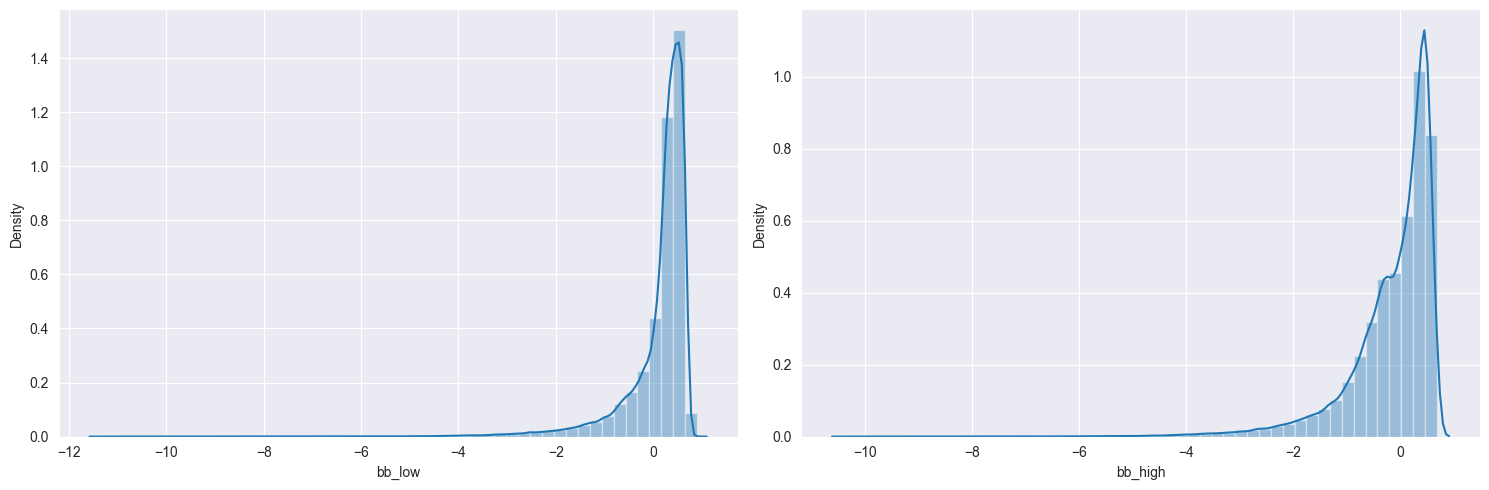

In [171]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_low'].dropna(), ax=axes[0])
sns.distplot(prices.loc[prices.dollar_vol_rank<100, 'bb_high'].dropna(), ax=axes[1])
sns.despine()
plt.tight_layout();

### Compute Average True Range

In [172]:
prices['NATR'] = prices.groupby(level='symbol', 
                                group_keys=False).apply(lambda x: 
                                                        talib.NATR(x.high, x.low, x.close))

In [173]:
def compute_atr(stock_data):
    df = ATR(stock_data.high, stock_data.low, 
             stock_data.close, timeperiod=14)
    return df.sub(df.mean()).div(df.std())

In [174]:
prices['ATR'] = (prices.groupby('symbol', group_keys=False)
                 .apply(compute_atr))

### Compute Moving Average Convergence/Divergence

In [175]:
# Apply the PPO function (from TA-Lib) per symbol group
ppo_values = prices.groupby(level='symbol')['close'].apply(talib.PPO)

# Ensure the index alignment before assigning the result back to the dataframe
prices['PPO'] = ppo_values.values


In [176]:
def compute_macd(close):
    macd = MACD(close)[0]
    return (macd - np.mean(macd))/np.std(macd)

In [177]:
prices['MACD'] = (prices
                  .groupby('symbol', group_keys=False)
                  .close
                  .apply(compute_macd))

### Combine Price and Meta Data

In [178]:
print(metadata.columns)


Index(['marketcap', 'sector'], dtype='object')


In [179]:
# Rename the sector column in metadata before joining
metadata = metadata.rename(columns={'sector': 'metadata_sector'})

# Join the metadata sector column to the prices dataframe
prices = prices.join(metadata[['metadata_sector']])


## Compute Returns

### Historical Returns

In [180]:
by_sym = prices.groupby(level='symbol').close
for t in T:
    prices[f'r{t:02}'] = by_sym.pct_change(t)

### Daily historical return deciles

In [181]:
for t in T:
    prices[f'r{t:02}dec'] = prices.groupby(level='date')[f'r{t:02}'].transform(
        lambda x: pd.qcut(x, q=10, labels=False, duplicates='drop')
    )


In [182]:
# Check if 'metadata_sector' exists instead of 'sector'
if 'metadata_sector' in metadata.columns:
    prices = prices.join(metadata[['metadata_sector']].rename(columns={'metadata_sector': 'sector'}))

# Now, perform the groupby operation
for t in T:
    prices[f'r{t:02}q_sector'] = prices.groupby(['sector', 'date'])[f'r{t:02}'].transform(
        lambda x: pd.qcut(x, q=10, labels=False, duplicates='drop')
    )


### Daily sector return deciles

In [183]:
for t in T:
    prices[f'r{t:02}_fwd'] = prices.groupby(level='symbol')[f'r{t:02}'].shift(-t)


### Compute Forward Returns

In [184]:
for t in [1, 5, 21]:
    prices[f'r{t:02}_fwd'] = prices.groupby(level='symbol')[f'r{t:02}'].shift(-t)

## Remove outliers

In [185]:
prices[[f'r{t:02}' for t in T]].describe()

,r01,r05,r10,r21,r42,r63
count,2.003775e+06,1.999775e+06,1.994775e+06,1.983775e+06,1.962775e+06,1.941775e+06
mean,7.519751e-04,3.726962e-03,7.353932e-03,1.555927e-02,3.113691e-02,4.619119e-02
std,2.166262e-02,4.791746e-02,6.579895e-02,9.467552e-02,1.325751e-01,1.618423e-01
min,-8.757416e-01,-8.768476e-01,-8.778415e-01,-8.802285e-01,-8.867366e-01,-8.863481e-01
25%,-8.088407e-03,-1.721664e-02,-2.291896e-02,-3.045918e-02,-3.531712e-02,-3.696833e-02
50%,6.561680e-04,3.702235e-03,7.173181e-03,1.503253e-02,2.899023e-02,4.217809e-02
75%,9.509191e-03,2.440601e-02,3.707177e-02,5.927618e-02,9.305628e-02,1.219666e-01
max,1.216425e+01,1.252657e+01,1.252657e+01,1.252657e+01,1.181643e+01,1.166968e+01


We remove daily returns above 100 percent as these are more likely to represent data errors; we are using the 100 percent cutoff here in a somewhat ad-hoc fashion; you would want to apply more careful exploratory and historical analysis to decide which assets are truly not representative of the sample period.

In [186]:
outliers = prices[prices.r01 > 1].index.get_level_values('symbol').unique()

In [187]:
prices = prices.drop(outliers, level='symbol')

## Create time and sector dummy variables

In [ ]:
prices['year'] = prices.index.get_level_values('date').year
prices['month'] = prices.index.get_level_values('date').month
prices['weekday'] = prices.index.get_level_values('date').weekday

In [192]:
# Convert sector to numeric values
prices['sector'] = pd.factorize(prices['sector'])[0].astype('int64')

# Convert other columns to int64
prices['year'] = prices['year'].astype('int64')
prices['month'] = prices['month'].astype('int64')
prices['weekday'] = prices['weekday'].astype('int64')


In [190]:
prices['year'] = prices.index.get_level_values('date').year
prices['month'] = prices.index.get_level_values('date').month
prices['weekday'] = prices.index.get_level_values('date').weekday

## Store Model Data

In [193]:
prices.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1994931 entries, ('AAPL', Timestamp('2010-01-04 00:00:00')) to ('NTCT', Timestamp('2017-12-29 00:00:00'))
Data columns (total 43 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   open             1994931 non-null  float64
 1   close            1994931 non-null  float64
 2   low              1994931 non-null  float64
 3   high             1994931 non-null  float64
 4   volume           1994931 non-null  float64
 5   dollar_vol       1994931 non-null  float64
 6   dollar_vol_rank  1994931 non-null  float64
 7   rsi              1981974 non-null  float64
 8   bb_high          1497045 non-null  float64
 9   bb_low           1489038 non-null  float64
 10  NATR             1981001 non-null  float64
 11  ATR              1981001 non-null  float64
 12  PPO              1970056 non-null  float64
 13  MACD             1962096 non-null  float64
 14  metadata_sector  1994931 non-null  obj

In [195]:
prices.drop(['open', 'close', 'low', 'high', 'volume'], axis=1).to_hdf('data.h5', 'model_data')